In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Hiragino Sans'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats as ss
import statsmodels.tsa as tsa
from statsmodels.sandbox.stats import runs
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale

import finalib as fl

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# E-Mini S&P500先物と金先物データ読み込み

In [21]:
dfsp_tmp = pd.read_csv('data/e-mini-sp500-200530/e-mini-sp500-daily.csv')
dfg_tmp = pd.read_csv(f'data/gold-200626/gold-daily.csv')
dfs = [dfsp_tmp, dfg_tmp]

prods = ['S&P500先物', '金先物']

# datetime indexに変換
def to_datetime_index(df):
    # DateTime列を追加
    df['datetime'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
    df = df.set_index('datetime', drop=True)
    df = df.drop(columns=['Date', 'Time'])
    return df

dfs = [to_datetime_index(df) for df in dfs]

# 対数変換した列を追加
def add_log_values(df):
    df['logO'] = np.log(df['Open'])
    df['logH'] = np.log(df['High'])
    df['logL'] = np.log(df['Low'])
    df['logC'] = np.log(df['Close'])
    df['logV'] = np.log(df['Vol'])
    df['logOI'] = np.log(df['OI'])

_ = [add_log_values(df) for df in dfs]

/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 価格、対数価格、価格階差、対数差収益率（100倍）のDFを作成

In [3]:
def to_log_return_ratio_df(df):
    diff_df = df.diff()
    close_df = df[['Close', 'logC']]
    diff_df = diff_df.rename(columns={'Close': 'CloseDiff', 'logC': 'logCDiff'})
    close_diff_df = diff_df[['CloseDiff', 'logCDiff']]
    rr_df = pd.concat([close_df, close_diff_df], axis=1)
    rr_df = rr_df.dropna()
    return rr_df

rr_dfs = [to_log_return_ratio_df(df) for df in dfs]

# 2019年の1年間のみのデータ

In [4]:
rrdfs2019 = [df[dt.datetime(2019, 1, 1):dt.datetime(2020, 1, 1)] for df in rr_dfs]

# 自己回帰モデルの残渣を調べる
残渣がホワイトノイズでなければ、モデルあてはめの信頼度は大きく低下する。

## 改めて対数差収益率をプロット

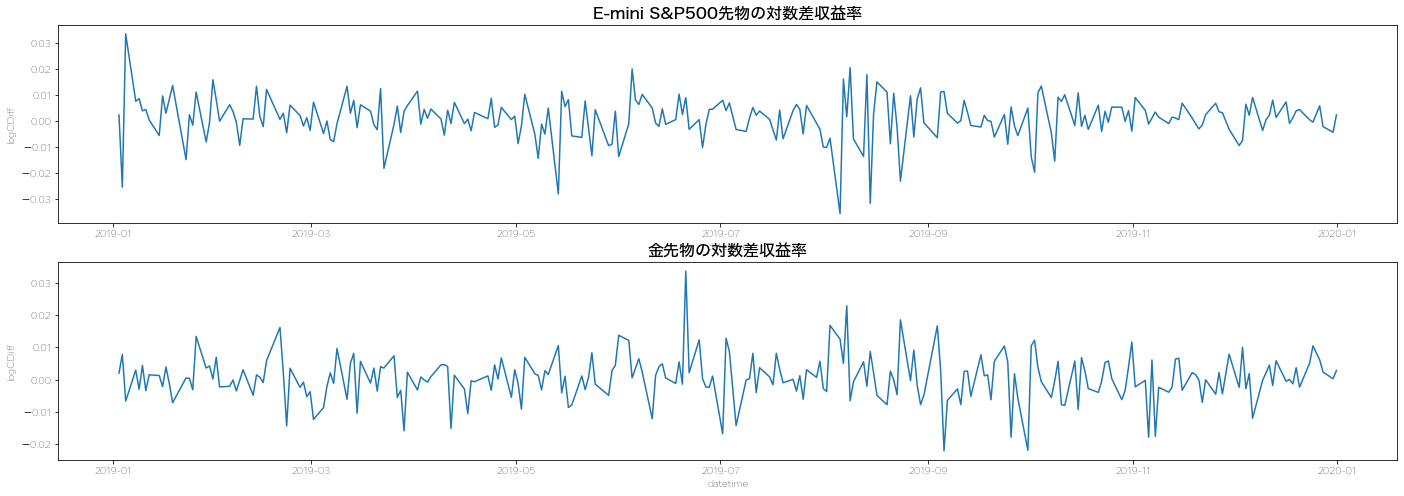

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(24, 8))

sns.lineplot(rrdfs2019[0].index, rrdfs2019[0]['logCDiff'], ax=ax[0])
sns.lineplot(rrdfs2019[0].index, rrdfs2019[1]['logCDiff'], ax=ax[1])

titles = ['E-mini S&P500先物の対数差収益率', '金先物の対数差収益率']
for i in range(2):
    ax[i].set_title(titles[i], fontsize=16, fontweight='semibold')

## まずは残渣を調べる回帰モデルを作成：最適な次数を持つAR(p)モデルをAICで自動選択
- AutoRegクラス（AR(p)モデル）：https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html
- AutoRegResultsクラス（fitの戻り値）：https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoRegResults.html
- モデル選択関数：https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.ar_select_order.html
  - モデル選択関数の使い方：https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html

In [43]:
# ar_select_order()という関数が用意されているのでコレを使ってモデル選択ができる
models = []
for i in range(2):
    # this is only selection, not fitting (??)
    sel = tsa.ar_model.ar_select_order(rrdfs2019[i]['logCDiff'].to_numpy(), maxlag=20, ic='aic', old_names=False)
    models.append(sel.model.fit())

for i, product in enumerate(prods):
    print(f"{product}の最適なAR(p)モデル")
    print(f"    AIC: {models[i].aic}, HQIC: {models[i].hqic}, BIC: {models[i].bic}")
    print(f"    選択されたラグ：{models[i].ar_lags}, ")
    if len(models[i].ar_lags):
        print(f"    推定された回帰式：収益率r(t) = {models[i].params[0]} + {models[i].params[1]} × r(t-{models[i].ar_lags[0]}) + ε(t)")

S&P500先物の最適なAR(p)モデル
    AIC: -9.601330671124034, HQIC: -9.584373733499085, BIC: -9.559193783405327
    選択されたラグ：[1], 
    推定された回帰式：収益率r(t) = 0.0011205147466286358 + -0.1362547629083485 × r(t-1) + ε(t)
金先物の最適なAR(p)モデル
    AIC: -9.913113085085497, HQIC: -9.90184190141793, BIC: -9.88510174312112
    選択されたラグ：[], 


# 残差を調べる
- ARモデルの誤差項であるε(t)はホワイトノイズを仮定しているため、モデルあてはめの残差がホワイトノイズになっていることを期待する
    - もしなっていなければこのモデルあてはめの信頼性は著しく低下する
- ホワイトノイズであれば、 `E[ε(t)] = 0`, `var(ε(t)) = σ^2`（定数） となるはず

## 1. 誤差平均（残差系列）を調べる
もし残差に時間依存の構造がなければ、
- 残差のコレログラムを描いても自己相関は見つからないはず
- ARモデルを当てはめてもAICでAR(0)モデルが選択されるはず
- Ljung-Box検定（自己相関検定）で「自己相関はない」という帰無仮説を棄却できないはず

### コレログラム

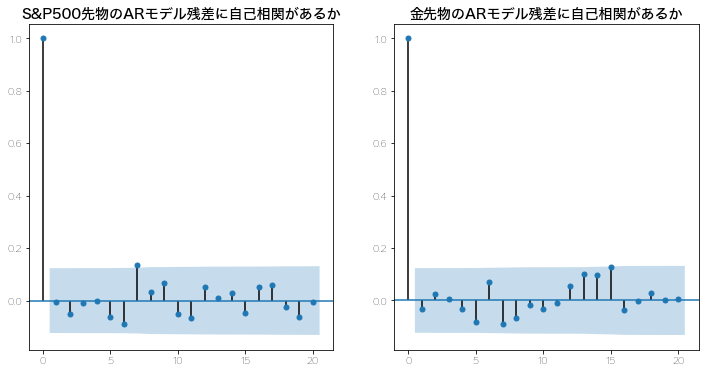

In [45]:
# コレログラム
"""
S&P500先物では ラグ=7 の時に自己相関が見られるため、残差にも時間依存がある可能性あり
金先物では自己相関は見られない
"""
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for i, prod in enumerate(prods):
    sm.graphics.tsa.plot_acf(models[i].resid, lags=20, ax=ax[i])
    ax[i].set_title(f'{prod}のARモデル残差に自己相関があるか', fontsize=14, fontweight='semibold')

plt.show()

### ARモデルの当てはめ

In [62]:
# ARモデルのあてはめ
"""
どちらも残差系列のARモデルはAR(0)となったため時間依存構造はないと考えて良い
--> 残差がホワイトノイズであることを否定しない
"""
resid_models = []
for i in range(2):
    sel = tsa.ar_model.ar_select_order(models[i].resid, maxlag=20, ic='aic', old_names=False)
    resid_models.append(sel.model.fit())

for i, product in enumerate(['S&P先物', '金先物']):
    print(f"{product}のモデル残差の最適なAR(p)モデル")
    print(f"    AIC: {resid_models[i].aic}, HQIC: {resid_models[i].hqic}, BIC: {resid_models[i].bic}")
    print(f"    選択されたラグ：{resid_models[i].ar_lags}, ")
    if len(resid_models[i].ar_lags):
        print(f"    推定された回帰式：収益率r(t) = {resid_models[i].params[0]} + {resid_models[i].params[1]} × r(t-{resid_models[i].ar_lags[0]}) + ε(t)")

S&P先物のモデル残差の最適なAR(p)モデル
    AIC: -9.609298798614073, HQIC: -9.597994173530775, BIC: -9.581207540134935
    選択されたラグ：[], 
金先物のモデル残差の最適なAR(p)モデル
    AIC: -9.913113085085497, HQIC: -9.90184190141793, BIC: -9.88510174312112
    選択されたラグ：[], 


### Ljung-Box検定

In [56]:
# 残差系列に対してLjung-Box検定
# 「自己相関はない」という帰無仮説
"""
例によって有意水準は10%とする
どちらの銘柄でも、全てのラグでpvalue > 0.1のため、「自己相関はない」という帰無仮説は棄却されない
"""
for i, prod in enumerate(prods):
    res_df = ss.diagnostic.acorr_ljungbox(models[i].resid, lags=20, return_df=True)
    print(res_df)

      lb_stat  lb_pvalue
1    0.004745   0.945081
2    0.653789   0.721160
3    0.677424   0.878501
4    0.679570   0.953824
5    1.732871   0.884733
6    3.819654   0.701067
7    8.572849   0.284795
8    8.831132   0.356741
9   10.069019   0.344927
10  10.730153   0.378924
11  11.883199   0.372487
12  12.628226   0.396632
13  12.651509   0.475076
14  12.891401   0.535092
15  13.457641   0.566995
16  14.167037   0.586271
17  15.159203   0.584015
18  15.300627   0.641232
19  16.357436   0.633312
20  16.364828   0.693749
      lb_stat  lb_pvalue
1    0.293967   0.587690
2    0.432888   0.805378
3    0.441301   0.931584
4    0.707780   0.950366
5    2.490813   0.777878
6    3.739159   0.711926
7    5.777669   0.565937
8    6.926561   0.544577
9    6.992116   0.637940
10   7.292353   0.697587
11   7.320378   0.772577
12   8.168566   0.771823
13  10.978678   0.612604
14  13.419598   0.493783
15  17.929279   0.266402
16  18.321566   0.305406
17  18.322714   0.368761
18  18.541104   0.420578


### どちらの銘柄も残差には自己相関はないと言えそう
- S&P500先物については、コレログラムでラグ=7の時の自己相関係数が相関なしの95%信頼区間を超えていたため自己相関ありの可能性あり
- しかしARモデルあてはめではAR(0)が選択されたし、Ljung-Box検定でもラグ=1〜20で全て帰無仮説は棄却されなかったから、総合評価として、残差系列に自己相関はないとみなして良さそう
- 金先物についてはコレログラム、ARモデルあてはめ、Ljung-Box検定の全ての結果は自己相関がないことを示唆する

## 2. 誤差分散（残差の2乗系列）を調べる
誤差平均の時と同様に、コレログラム、ARモデルあてはめ、Ljung-Box検定を行う

In [59]:
# 誤差分散
resid_vars = [model.resid ** 2 for model in models]

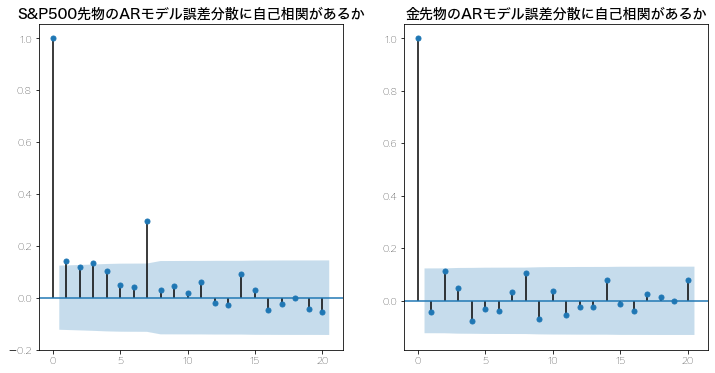

In [61]:
# コレログラム
"""
S&P500先物では ラグ=1,3,7 の時に自己相関が見られるため、残差にも時間依存がある可能性あり
金先物では自己相関は見られない
"""
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for i, prod in enumerate(prods):
    sm.graphics.tsa.plot_acf(resid_vars[i], lags=20, ax=ax[i])
    ax[i].set_title(f'{prod}のARモデル誤差分散に自己相関があるか', fontsize=14, fontweight='semibold')

plt.show()

In [64]:
# ARモデルのあてはめ
"""
S&P500先物については ラグ＝(1,2,3,4,5,6,7) という時間依存山盛りのARモデルが選択された
--> 誤差分散はホワイトノイズに従っていない

金先物については誤差分散のARモデルはAR(0)となったため時間依存構造はないと考えて良い
--> 誤差分散がホワイトノイズであることを否定しない
"""
var_models = []
for i in range(2):
    sel = tsa.ar_model.ar_select_order(resid_vars[i], maxlag=20, ic='aic', old_names=False)
    var_models.append(sel.model.fit())

for i, product in enumerate(['S&P先物', '金先物']):
    print(f"{product}のモデル誤差分散の最適なAR(p)モデル")
    print(f"    AIC: {var_models[i].aic}, HQIC: {var_models[i].hqic}, BIC: {var_models[i].bic}")
    print(f"    選択されたラグ：{var_models[i].ar_lags}, ")
    if len(var_models[i].ar_lags):
        print(f"    推定された回帰式：収益率r(t) = {var_models[i].params[0]} + {var_models[i].params[1]} × r(t-{var_models[i].ar_lags[0]}) + ε(t)")

S&P先物のモデル誤差分散の最適なAR(p)モデル
    AIC: -17.830205972051854, HQIC: -17.778254350546295, BIC: -17.701212062102517
    選択されたラグ：[1 2 3 4 5 6 7], 
    推定された回帰式：収益率r(t) = 2.4960099217637332e-05 + 0.010876006196379306 × r(t-1) + ε(t)
金先物のモデル誤差分散の最適なAR(p)モデル
    AIC: -18.2964132886684, HQIC: -18.285142105000833, BIC: -18.268401946704024
    選択されたラグ：[], 


In [67]:
# 残差系列に対してLjung-Box検定
# 「自己相関はない」という帰無仮説
"""
例によって有意水準は10%とする
S&P500先物では、ラグ=3以上では全て、pvalue < 0.1のため帰無仮説は棄却され、自己相関があることが示唆される
金先物では、全てのラグでpvalue > 0.1のため、「自己相関はない」という帰無仮説は棄却されない
"""
for i, prod in enumerate(prods):
    res_df = ss.diagnostic.acorr_ljungbox(resid_vars[i], lags=20, return_df=True)
    print(res_df)

      lb_stat  lb_pvalue
1    5.069942   0.024344
2    8.740371   0.012649
3   13.280338   0.004068
4   16.044570   0.002960
5   16.640376   0.005235
6   17.082039   0.008986
7   39.615357   0.000001
8   39.856483   0.000003
9   40.376262   0.000006
10  40.477789   0.000014
11  41.508342   0.000020
12  41.625825   0.000038
13  41.832037   0.000070
14  44.102157   0.000057
15  44.362631   0.000096
16  44.991102   0.000139
17  45.169606   0.000230
18  45.169924   0.000392
19  45.680464   0.000550
20  46.577175   0.000671
      lb_stat  lb_pvalue
1    0.478494   0.489105
2    3.740694   0.154070
3    4.344913   0.226548
4    5.849866   0.210644
5    6.118659   0.294844
6    6.478618   0.371760
7    6.752644   0.455081
8    9.614377   0.293141
9   10.838023   0.286975
10  11.239829   0.339141
11  11.975450   0.365491
12  12.110845   0.436819
13  12.254776   0.506871
14  13.954651   0.453095
15  14.004933   0.525155
16  14.380952   0.570357
17  14.578572   0.625808
18  14.624698   0.687555


### 残差の2乗系列についてはS&P500先物では自己相関あり、金先物では無し
- S&P500先物では、コレログラム・ARモデルあてはめ・Ljung-Box検定の全てで自己相関があるという結果が出た
- 金先物では、全ての検定で自己相関はないという結果が出た

残差系列と残差の2乗系列の結果を総合して、
- S&P500先物のARモデルあてはめ残差はホワイトノイズとはみなせず、時間依存関係があることが示唆される
- 金先物のARモデルあてはめ残差はホワイトノイズとみなせそう